# REVERB FILTER

## Setup

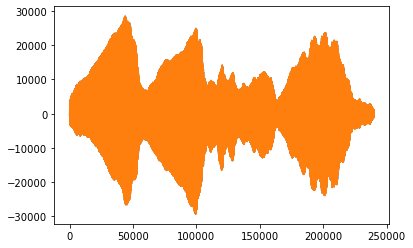

In [1]:
#import sounddevice as sd (might want to keep for mic input even though ehhh it's kinda well not the best)
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write, read

audio_file = read("sample.wav")
audio_sample_rate = audio_file[0]
audio_samples = np.array(audio_file[1], dtype=float)

plt.plot(audio_samples)

In [2]:
# Default reverb parameters, assumably will come from sensor inputs later in the process

defaults = {
    "delay" : 500,
    "decay" : 0.5,
    "moist" : 1}

## Filter declarations

**Comb filter:**
* expand the current sample to {delay_size} next samples with decay factor

In [3]:
def combFilter(samples, delay_in_mili, decay_factor, sample_rate):
    delay_size = int(delay_in_mili * sample_rate / 1000)
    combFilter_samples = samples[:]

    for i in range(len(samples)-delay_size):
        combFilter_samples[i + delay_size] += (combFilter_samples[i] * decay_factor)

    return combFilter_samples


def allpassFilter(samples, sample_rate):
    delay_size = int(89.27 * sample_rate / 1000)
    allpassFilter_samples = samples[:]
    decay_factor = 0.131

    # Algorithm:
    for i in range(len(samples)):
        if (i - delay_size >= 0):
            allpassFilter_samples[i] += -decay_factor * \
                allpassFilter_samples[i - delay_size]
        if (i - delay_size >= 1):
            allpassFilter_samples[i] += decay_factor * \
                allpassFilter_samples[i + 20 - delay_size]

    max_val = np.amax([abs(item) for item in allpassFilter_samples])
    allpassFilter_samples = [item/max_val for item in allpassFilter_samples]

    return allpassFilter_samples

## Implementation

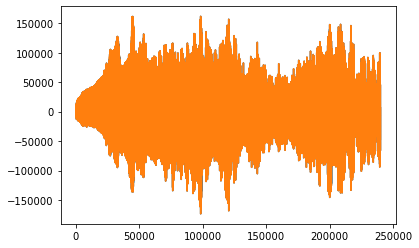

In [4]:
CF_samples_1 = combFilter(audio_samples, defaults["delay"], defaults["decay"], audio_sample_rate)
CF_samples_2 = combFilter(audio_samples, defaults["delay"] - 11.73, defaults["decay"] - 0.1313, audio_sample_rate)
CF_samples_3 = combFilter(audio_samples, defaults["delay"] + 19.31, defaults["decay"] - 0.2743, audio_sample_rate)
CF_samples_4 = combFilter(audio_samples, defaults["delay"] - 7.97, defaults["decay"] - 0.31, audio_sample_rate)

postcomb_audio_samples = CF_samples_1 + CF_samples_2 + CF_samples_3 + CF_samples_4

plt.plot(postcomb_audio_samples)

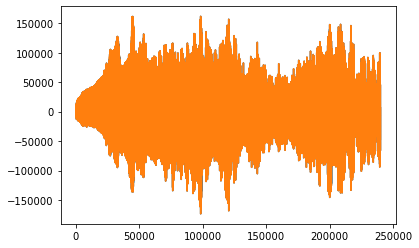

In [5]:
# Dry/Wet mix in the output audio
moist_mix = [0] * len(audio_samples)
for i in range(len(audio_samples)):
    moist_mix[i] = ((1 - defaults["moist"]) * audio_samples[i]) + (defaults["moist"] * postcomb_audio_samples[i])

plt.plot(moist_mix)

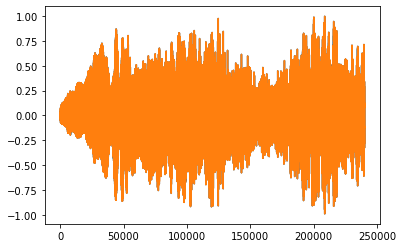

In [6]:
AP_samples_1 = allpassFilter(moist_mix, audio_sample_rate)
AP_samples_2 = allpassFilter(AP_samples_1, audio_sample_rate)

reverbed_samples = np.array(AP_samples_2)
plt.plot(reverbed_samples)

In [7]:
write("reverb_output.wav", audio_sample_rate, reverbed_samples)